# Improving performance of electron-specific ML algorithms with dimensionally reduced "split chi2" track-trigger variables

Wow, that was a long one.

## Abstract

For the relevant background on machine learning for the track-trigger, read this repository's [README](README.md).

This study had three goals:

- First, determine whether the introduction of new track properties, namely **chi2rphi** and **chi2rz**, improve the performance of machine learning algorithms that can discriminate between electron tracks and fake tracks.  
*This was found to be the case, but not as much as we'd hoped*: the area under the ROC curves for the models increased by 2-3%.

- Second, determine whether we need "fancy machine learning", or whether the performance of new **chi2rz** cuts on the maybe-electrons performed better.  
*In all cases, the models performed significantly better*. The question of computational time is ignored in this study.

- Third, determine whether we even need an electron-specific discriminator at all — perhaps a general track quality discriminator would perform better on electrons than one trained specifically for electrons.  
*So far, it's not looking good for an electron-specific discriminator.* There was a previous study by Claire Savard in which she created a general track-quality discriminator, and the...

## Introduction

### Background: Why are these new variables useful for electron identification?

#### Well, what are they?

The chi2 variables here represent how well the stubs of a track line up with those of an ideal track, given the track's parameters. As you might guess from the name, chi2rphi is the component of chi2 in the r-phi plane of the detector, while chi2rz is the component in the r-z plane. More information about these variables can be found in [the slideshow presentation in this repository](split_chi2.pdf).

#### And what about the electrons?

As electrons have low mass, their interactions with the detector will bend their tracks. This causes their stubs to have a high chi2, and will often cause electrons to be mistaken for fake tracks. However, this "bouncing" only occurs in the r-phi plane, meaning that chi2rz-based predictions are much less likely to mistake electrons for fake tracks. So, let's see what machine learning has to say about that.

### Methods

To answer the questions above, four sets of discriminators were made, each with a neural network, a gradient boosted decision tree, and a set of predictive cuts. Each set differed from the others in **the data sample that they were trained on** and **the track properties that were used in training**.

Note that, despite the training sample, all 

Datasets:
- *General models*: models 



The Monte-Carlo sample set used for this is:
- a Z to electron-positron sample
- with around 9000 events
- with a pileup of 200
- run on the D49 detector geometry
    - with T14 tracker geometry.

Most of the code here is run using the `ntupledicts` package, which can be found [here](https://github.com/cqpancoast/ntupledicts), along with a simple tutorial that covers all code used.

A few pieces from the `matplotlib.pyplot` package are used as well.

### Future work

#### Model Improvement

All models in question may see improvement by optimizing model hyperparameters and making use of the tracklet seed variable during training.

#### Model Implementation

The implementation details of a model in hardware are not yet known... [here](https://indico.cern.ch/event/876306/contributions/3710752/attachments/1974066/3284864/L1T_1_22_20.pdf)

---

In [1]:
# Import everything from ntupledicts except plotting modules.
from ntupledicts import load as ndload
from ntupledicts import operations as ndops
from ntupledicts import analyze as ndanl
from ntupledicts.operations import select as sel
from ntupledicts.ml import data as ndmldata
from ntupledicts.ml import predict as ndmlpred
from ntupledicts.ml import models as ndmlmodels

In [2]:
# Set randomness seed to use throughout study.
random_seed = 42

## Data Acquisition

Grab tracks from stored ntuples, perform cuts, process into datasets.

Four datasets are created:
- A *general sample* using `D49_ZEE`, `D49_ZMM`, and `D49_QCD`, which randomly cuts the number of real tracks down to the number of fakes.
- An *electron-specific sample* using only `D49_ZEE` that selects only electrons, and then cuts down the number of fake tracks to the number of electrons.
- The other two datasets are versions of these two datasets restricted to `pT > 20 GeV`, as much of the interesting physics analysis will take place above that threshold.

### Load All Data From `.root` Files

This may take a few minutes — the author of `ntupledicts` has not yet taken a course in algorithms at the time of writing.
Thankfully, this study is a Jupyter Notebook.

In [3]:
# List the root files we want ntuples from
input_files = ["eventsets/D49_ZEE.root", "eventsets/D49_ZMM.root", "eventsets/D49_QCD.root"]

# What track properties do we want available to play with?
# We can select out which ones we want our models to train on later
track_properties = ["pt", "eta", "z0", "nstub", "hitpattern",
                    "chi2", "bendchi2", "chi2rphi", "chi2rz",
                    "matchtp_pdgid", "genuine", "loose"]
properties_by_track_type = {"trk": track_properties}

# Create ntuple dict from input files
ntuple_dict = ndload.root_files_to_ntuple_dict(input_files, properties_by_track_type)

### Define Selectors

`ntupledicts` uses "selectors" to perform cuts on tracks.
For convenience, there are defined together here, along with the appropriate track property to act on.

In [4]:
electron_sel = sel([sel(11), sel(-11)])  # matchtp_pdgid: selects electrons and antielectrons
not_gen_sel = sel(0)                     # genuine: selects not genuine tracks; or genuine == 0
genuine_sel = sel(1)                     # genuine: selects genuine tracks; or genuine == 1
pt_gt_20_sel = sel(20, float("inf"))     # pt: selects tracks with pT >= 20 GeV

### Get not genuine tracks

In [5]:
# Find all not genuine tracks, with all pTs and with pT > 20 GeV.
# This takes a while, and so is performed for both datasets.
trk_not_gens = ndops.cut_track_prop_dict(ntuple_dict["trk"], {"genuine": not_gen_sel})
print("Number of not genuine tracks: {}"
      .format(ndops.track_prop_dict_length(trk_not_gens)))

trk_not_gens_pt20 = ndops.cut_track_prop_dict(trk_not_gens, {"pt": pt_gt_20_sel})
print("Number of not genuine tracks with pT > 20 GeV: {}"
      .format(ndops.track_prop_dict_length(trk_not_gens_pt20)))

Number of not genuine tracks: 301548
Number of not genuine tracks with pT > 20 GeV: 36359


### Make Electron-Specific Datasets

In [6]:
# Get genuine electron tracks.
trk_els = ndops.cut_track_prop_dict(ntuple_dict["trk"],
                                    {"matchtp_pdgid": electron_sel, "genuine": genuine_sel})
print("Number of electron tracks: {}"
      .format(ndops.track_prop_dict_length(trk_els)))

# Now, add in an equal number of fake tracks and shuffle the track properties dict.
# There are more non-genuines than electrons, so the non-genuines are cut down to size in mix_track_prop_dicts.
el_spec_tpd = ndops.mix_track_prop_dicts([trk_els, trk_not_gens], seed=random_seed)

Number of electron tracks: 55207


In [7]:
# Now make a dataset from the previous one composed of only pt > 20 GeV tracks.
trk_els_pt20 = ndops.cut_track_prop_dict(trk_els, {"pt": pt_gt_20_sel})
print("Number of electron tracks with pT > 20 GeV: {}"
      .format(ndops.track_prop_dict_length(trk_els_pt20)))

# Again, add them together and shuffle the track properties dict.
# There are still more non-genuines than genuines, so the non-genuines are cut down to size.
el_spec_pt20_tpd = ndops.mix_track_prop_dicts([trk_els_pt20, trk_not_gens_pt20], seed=random_seed)

Number of electron tracks with pT > 20 GeV: 8758


### Make General (All Tracks) Datasets

In [8]:
# Test general track classifier: simply cut down number of reals to number of fakes.
trk_gens = ndops.cut_track_prop_dict(ntuple_dict["trk"], {"genuine": genuine_sel})
print("Number of genuine tracks: {}"
      .format(ndops.track_prop_dict_length(trk_gens)))

# Cut genuines down to not genuine size, add together, and shuffle.
general_tpd = ndops.mix_track_prop_dicts([trk_gens, trk_not_gens], seed=random_seed)

Number of genuine tracks: 3721911


In [9]:
# Now make a dataset from the previous one composed of only pt > 20 GeV tracks.
trk_gens_pt20 = ndops.cut_track_prop_dict(trk_gens, {"pt": pt_gt_20_sel})
print("Number of genuine tracks with pT > 20 GeV: {}"
      .format(ndops.track_prop_dict_length(trk_gens_pt20)))

# Again, add them together and shuffle the track properties dict.
# There are still more genuines than non-genuines, so the genuines are cut down to size.
general_pt20_tpd = ndops.mix_track_prop_dicts([trk_gens_pt20, trk_not_gens_pt20], seed=random_seed)

Number of genuine tracks with pT > 20 GeV: 51616


We'll want to act on these track property dictionaries together, so we put them into a dictionary.

In [10]:
track_prop_dicts = {"el_spec": el_spec_tpd,
                    "el_spec_pt20": el_spec_pt20_tpd,
                    "general": general_tpd,
                    "general_pt20": general_pt20_tpd}
train_dataset_names = list(track_prop_dicts.keys())

### Add Stub-Based Track Properties

Use hitpattern and eta to determine how many missing PS stubs there are for each track.
See `ntupledicts.analyze` for documentation.

In [12]:
# Count layers meeting these conditions for each track.
missing_PS_layer = lambda expected, hit, ps: ps and expected and not hit

for dataset_name in track_prop_dicts.keys():
    track_prop_dicts[dataset_name]["missingPS"] = ndanl.create_stub_info_list(
                                                        track_prop_dicts[dataset_name],
                                                        ndanl.basic_process_stub_info(missing_PS_layer))

### Process into Datasets

Process the track prop dicts above into `TrackPropertiesDataset`s.

In [15]:
common_track_props = ["bendchi2", "nstub", "missingPS"]  
    # Track properties that all sets of models will use.
label_property = "genuine"  # What property are we trying to predict?
split_list = [.7, .2, .1]   # How many datasets should we create, and with what relative sizes?

datasets = {}
for dataset_name, track_prop_dict in track_prop_dicts.items():
    datasets[dataset_name] = {}
    datasets[dataset_name]["train"], datasets[dataset_name]["eval"], datasets[dataset_name]["test"] =\
        ndmldata.TrackPropertiesDataset(track_prop_dict,
                                        label_property,
                                        common_track_props).split(split_list)

## Making Discriminators

Counting everything up, it looks like we're going to have a whopping 24 discriminators, one for each permutation of the below:
- *Dataset trained on*: **[ electron-specific, general ]** (models only)
- *Train dataset pT range*: **[ all pT values, only pT >= 20 GeV ]** (models only)
- *Track properties trained on*: common track properties above, and **[ chi2, chi2rphi and chi2rz ]**
  - Note that the training properties above don't include pT.
    Models trained on pT are found to discriminate too heavily against lower tracks.
- *Discriminator type*: **[ simple cuts, gradient boosted decision tree, neural network ]**

We actually only have 19, as cuts are mostly training-dataset agnostic, but this is largely ignored for simplicity's sake.

### Clarifying Point: A Look at Some Confusing Variables

#### `discriminators`

All discriminators are going to be stored in a dictionary called `discriminators`.
To make things clear, this is a dictionary from **discriminator type** to **train dataset name** (including both electron vs. general and pt all vs. 20 info) to **discriminator set**, which indicates the track properties that were available for a discriminator to use.

Here are the values those keys will be able to take by the end of model creation:
- **discriminator type**: [ `"NN"`, `"GBDT"`, `"cut"` ]
- **train dataset name**: [ `"el_spec"`, `"el_spec_pt20"`, `"general"`, `"general_pt20"` ]
- **discriminator set**: [ `"chi2"`, `"split_chi2"` ]

#### `datasets`

All datasets are already stored in a dictionary called `datasets`.
This is a dictionary from **train dataset name** to **dataset type** to dataset.

Here are the values those keys are able to take:
- **train dataset name**: same as above, so [ `"el_spec"`, `"el_spec_pt20"`, `"general"`, `"general_pt20"` ]
- **dataset type**: [ `"train"`, `"eval"`, `"test"` ]

### Predictive Models

In [16]:
# A map from the names of the model sets to the properties they have in addition to the common properties.
model_sets_dict = {"chi2": ["chi2"], "split_chi2": ["chi2rz", "chi2rphi"]}
model_set_names = list(model_sets_dict.keys())

In [18]:
# Make our models and predictive cuts
discriminators = {"NN": {}, "GBDT": {}}  # cuts will be set later
for dataset_name, tp_datasets in datasets.items():  # iterate through train datasets
    discriminators["NN"][dataset_name] = {}
    discriminators["GBDT"][dataset_name] = {}
    
    for model_set_name, model_set_track_props in model_sets_dict.items():  # iterate through model sets

        # Set dataset active properties to common and set-specific properties
        for dataset_type in tp_datasets.keys():  # iterate through train, eval, test
            tp_datasets[dataset_type].set_active_data_properties(common_track_props + model_set_track_props)

        print("\n")
        print("Now training models of set '{}' using dataset '{}' and set-specific properties {}."
              .format(model_set_name, dataset_name, model_set_track_props))

        discriminators["NN"][dataset_name][model_set_name] = ndmlmodels.make_neuralnet(tp_datasets["train"],
                                                                                       eval_dataset=tp_datasets["eval"],
                                                                                       hidden_layers=[15, 8],
                                                                                       epochs=3)
        discriminators["GBDT"][dataset_name][model_set_name] = ndmlmodels.make_gbdt(tp_datasets["train"])



Now training models of set 'chi2' using dataset 'el_spec' and set-specific properties ['chi2'].
Epoch 1/3
25763/25763 [==============================] - 36s 1ms/step - loss: 0.5510 - accuracy: 0.7073 - val_loss: 0.5414 - val_accuracy: 0.7173
Epoch 2/3
25763/25763 [==============================] - 32s 1ms/step - loss: 0.5431 - accuracy: 0.7139 - val_loss: 0.5392 - val_accuracy: 0.7183
Epoch 3/3
25763/25763 [==============================] - 32s 1ms/step - loss: 0.5427 - accuracy: 0.7147 - val_loss: 0.5409 - val_accuracy: 0.7192


Now training models of set 'split_chi2' using dataset 'el_spec' and set-specific properties ['chi2rz', 'chi2rphi'].
Epoch 1/3
25763/25763 [==============================] - 33s 1ms/step - loss: 0.5069 - accuracy: 0.7453 - val_loss: 0.4943 - val_accuracy: 0.7555
Epoch 2/3
25763/25763 [==============================] - 34s 1ms/step - loss: 0.4973 - accuracy: 0.7527 - val_loss: 0.4945 - val_accuracy: 0.7547
Epoch 3/3
25763/25763 [==============================]

### Predictive Cuts

These cuts were simply chosen by trial and error, seeing what produced the points on the ROC curves below with the highest true positive rate and lowest false positive rate.

In [19]:
# Define predictive cuts in the same form as the model dictionaries
chi2_cuts = {"chi2": sel(0, 20), "bendchi2": sel(0, 2)}
el_spec_split_chi2_cuts = {"chi2rz": sel(0, 1), "bendchi2": sel(0, 2)}
    # Chi2rz cuts perform much better for electrons than chi2rphi
general_split_chi2_cuts = {"chi2rphi": sel(0, 20), "chi2rz": sel(0, 1), "bendchi2": sel(0, 2)}

el_spec_cut_set = {"chi2": chi2_cuts, "split_chi2": el_spec_split_chi2_cuts}
general_cut_set = {"chi2": chi2_cuts, "split_chi2": general_split_chi2_cuts}

discriminators["cut"] = {"el_spec": el_spec_cut_set,
                         "el_spec_pt20": el_spec_cut_set,
                         "general": general_cut_set,
                         "general_pt20": general_cut_set}

## Discriminator Predictions

Create two test datasets: `original_test_ds` and `single_el_test_ds`.
Both are made up of an even number of electrons and fake tracks.

The former is made up of tracks rom the original sample that were not trained on, and the latter is made up of tracks from a SingleEl sample with a flat pT distribution from 2 to 100 GeV.

All 24 discriminators will store their predictions of the tracks in the datasets themselves, accessible by a unique discriminator key.

### More Confusing Variables

#### `original_test_ds` and  `single_el_test_ds`

*Type: `ndmldata.TrackPropertiesDict`*

`original_test_ds` is simply `datasets["el_spec"]["test"]`, which seems weird, but hear me out.
We choose this to store predictions because `datasets["el_spec"]["test"]` is the largest dataset from the trained-on samples that has an equal proportion of electrons and fakes with a non-restricted pT distribution.
That is, it has the form of the data we want — *now we can use models trained from other datasets to make predictions on this one*.

`single_el_test_ds`, including its predictions, is of the same form as `original_test_ds`, except the tracks that it stores are a mix of a SingleEl sample (flat pT, 2 to 100) and a random set of fakes from the original root samples.
**This is critical, as we can evaluate performance of the models on a less biased pT distribution.**

Both datasets will store predictions from every discriminator using `ds.set_prediction({discriminator_key}, {list of predictions of dataset label})` and accessed by `ds.get_prediction({discriminator_key})`.

The discriminator key uniquely identifies each of the 24 discriminators we're using, and is of the form `"{discriminator type}_{model set name}_{model train dataset}"`.:
- **discriminator type**: [ `"NN"`, `"GBDT"`, `"cut"` ]
- **model set name**: [ `"chi2"`, `"split_chi2"` ]
- **model train dataset**: [ `"el_spec"`, `"el_spec_pt20"`, `"general"`, `"general_pt20"` ]

In [22]:
# The easy dataset. To get the single el flat pT dataset, we'll have to do some more complicated stuff. (Below.)
original_test_ds = datasets["el_spec_pt20"]["test"]

### Making `single_el_test_ds`

To test our models' performances on a broad pT range, we'll use a SingleEl sample with a flat pT distribution from 2 to 100 GeV.
In the same way that we made our datasets above, we will mix these electrons with an equal number of random fake tracks.

In [24]:
# List the root files we want ntuples from (just one this time)
input_files = ["eventsets/SingleE_PU200.root"]

# What track properties do we want available to play with?
track_properties = ["pt", "eta", "z0", "nstub", "hitpattern",
                    "chi2", "bendchi2", "chi2rphi", "chi2rz",
                    "matchtp_pdgid", "genuine", "loose"]
properties_by_track_type = {"trk": track_properties}

# Create track prop dict from input files
single_el_tpd = ndload.root_files_to_ntuple_dict(input_files, properties_by_track_type)["trk"]

In [31]:
# Get single electron tracks.
single_els = ndops.cut_track_prop_dict(single_el_tpd,
                                    {"matchtp_pdgid": electron_sel, "genuine": genuine_sel})
print("Number of electron tracks from SingleEl dataset: {}"
      .format(ndops.track_prop_dict_length(single_els)))

# Now, add in an equal number of fake tracks and shuffle the track properties dict.
single_el_tpd = ndops.mix_track_prop_dicts([single_els, trk_not_gens], seed=random_seed)

Number of electron tracks from SingleEl dataset: 28134
28134


In [32]:
# Count layers meeting these conditions for each track.
missing_PS_layer = lambda expected, hit, ps: ps and expected and not hit

single_el_tpd["missingPS"] = ndanl.create_stub_info_list(single_el_tpd,
    ndanl.basic_process_stub_info(missing_PS_layer))

In [33]:
# That wasn't that hard!
label_property = "genuine"
single_el_test_ds = ndmldata.TrackPropertiesDataset(single_el_tpd, label_property)

### Storing Discriminator Predictions

Have discriminators make predictions on the data in `original_test_ds` and `single_el_test_ds`, and store them by their discriminator key, which is detailed above.
This will take a hot second.

In [37]:
for test_ds in [original_test_ds, single_el_test_ds]:  # iterate through our two test datasets
    for train_dataset_name in train_dataset_names:  # iterate through names of trained-on datasets

        # Make model predictions
        for model_type in ["NN", "GBDT"]:
            for model_set_name, model_set_track_props in model_sets_dict.items():
                discriminator_key = "{}_{}_{}".format(model_type, model_set_name, train_dataset_name)

                test_ds.add_prediction(
                    discriminator_key,
                    ndmlpred.predict_labels(
                        discriminators[model_type][train_dataset_name][model_set_name],
                        test_ds.get_data(common_track_props + model_set_track_props)))

        # Make cut predictions
        for cut_set_name, cut in discriminators["cut"][train_dataset_name].items():
            discriminator_key = "cuts_{}_{}".format(cut_set_name, train_dataset_name)

            test_ds.add_prediction(discriminator_key,
                                   ndmlpred.predict_labels_cuts(cut, test_ds))
    
print("Prediction lists now accessible from both the original test dataset and the single electron dataset: \n{}"
      .format(original_test_ds.get_all_prediction_names()))

Generating prediction with discriminator key: NN_chi2_el_spec
Generating prediction with discriminator key: NN_split_chi2_el_spec
Generating prediction with discriminator key: GBDT_chi2_el_spec
Generating prediction with discriminator key: GBDT_split_chi2_el_spec
Generating prediction with discriminator key: cuts_chi2_el_spec
Generating prediction with discriminator key: cuts_split_chi2_el_spec
Generating prediction with discriminator key: NN_chi2_el_spec_pt20
Generating prediction with discriminator key: NN_split_chi2_el_spec_pt20
Generating prediction with discriminator key: GBDT_chi2_el_spec_pt20
Generating prediction with discriminator key: GBDT_split_chi2_el_spec_pt20
Generating prediction with discriminator key: cuts_chi2_el_spec_pt20
Generating prediction with discriminator key: cuts_split_chi2_el_spec_pt20
Generating prediction with discriminator key: NN_chi2_general
Generating prediction with discriminator key: NN_split_chi2_general
Generating prediction with discriminator key

## Plotting Predictions

Just in case you haven't been keeping track, I have — we now have 48 predictions!
That's two (for the original sample and for the single el sample) for each of our 24 (19 unique) discriminators.

These plots will measure the true positive rate and false positive rate (TPR and FPR) of these predictions with respect to various threshold values and track properties.

In [38]:
from ntupledicts import plot as ndplot
from ntupledicts.ml import plot as ndmlplot
from matplotlib.pyplot import cla, sca, gca, show, axhline

(These import statements are down here for debug purposes - so we don't have to rerun all the cells to change something in `ml.plot` suite or add some new `matplotlib` import.)

### Particle TPR and FPR by Threshold

Plot TPR and FPR for particles of a particular type as the threshold for assigning probablistic values to either genuine or not genuine shifts from zero to one. Make plots for both sets of models to compare performance.

In [48]:
def plot_tpr_fpr_by_threshold(test_ds, test_ds_name, train_ds_name, model_set_name, num_thresholds=30):
    """Make and show two graphs: one of TPR, and the other of FPR, for the
    predictions of the given test dataset specified by the train dataset
    name and the model set name. Also accepts the number of thresholds."""

    predictions_to_plot = list(filter(lambda pred_name:
                                      train_ds_name in pred_name and model_set_name in pred_name,
                                      test_ds.get_all_prediction_names()))

    for pred_comparison, pred_comp_name in zip(
            [ndmlpred.true_positive_rate, ndmlpred.false_positive_rate],
            ["TPR", "FPR"]):
        ax = gca()
        for pred_name in predictions_to_plot:
            if "cut" in pred_name:  # cut predictions are not probablistic and so do not vary by threshold
                ax.axhline(pred_comparison(test_ds.get_labels(),
                                           test_ds.get_prediction(pred_name))[0],
                           label=pred_name,
                           color="yellow" if "split" in pred_name else "purple")
            else:
                ax = ndmlplot.plot_pred_comparison_by_threshold(test_ds,
                                                                pred_name, pred_comparison, 
                                                                thresholds=num_thresholds,
                                                                legend_id=pred_name, ax=ax)
        ax.set_ylabel(pred_comp_name)
        ax.set_title("{} of {} model predictions by threshold for {}"
                     .format(pred_comp_name, model_set_name, test_ds_name))
        ax.legend()
        show()
        cla()

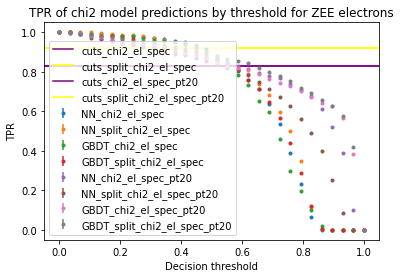

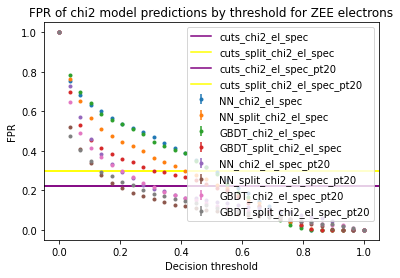

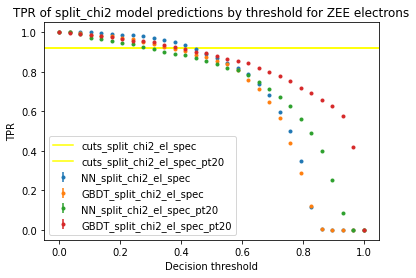

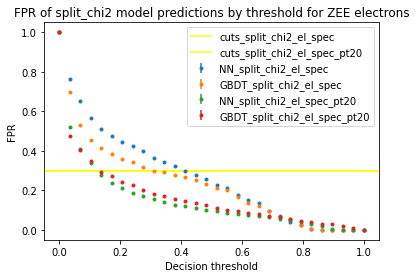

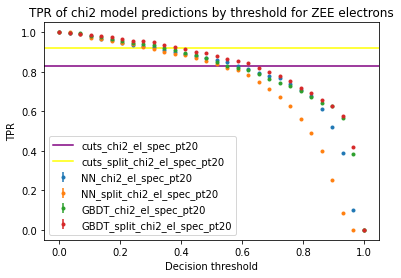

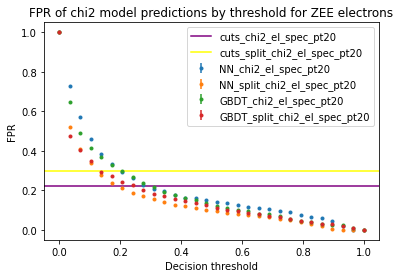

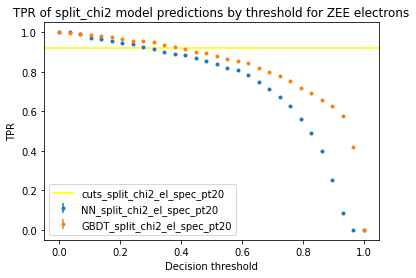

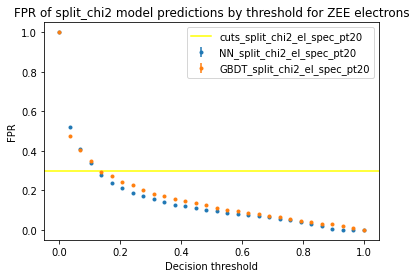

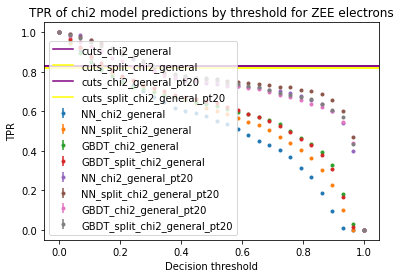

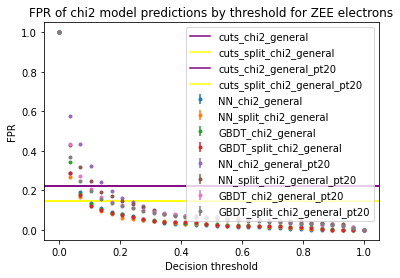

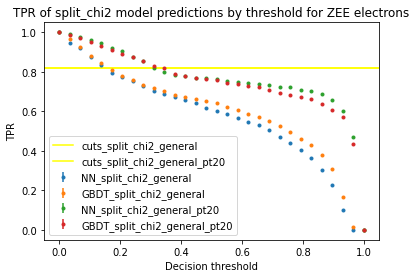

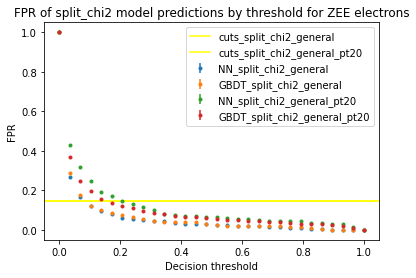

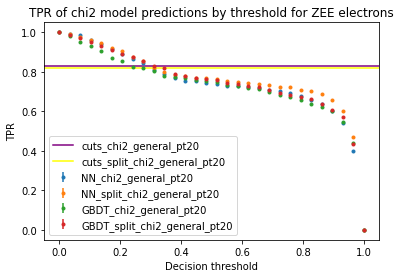

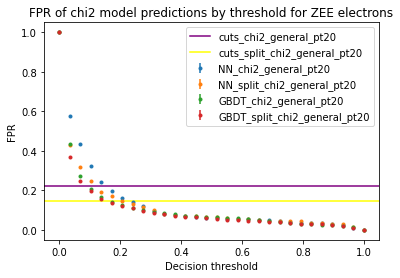

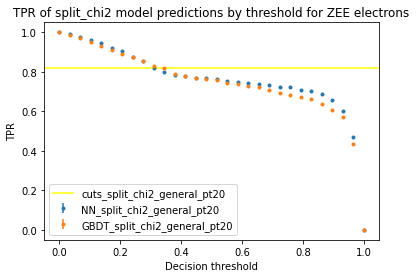

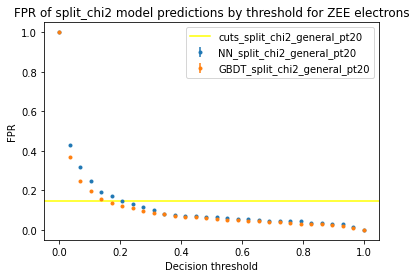

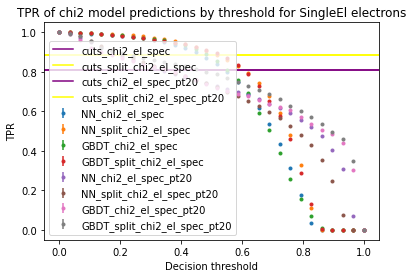

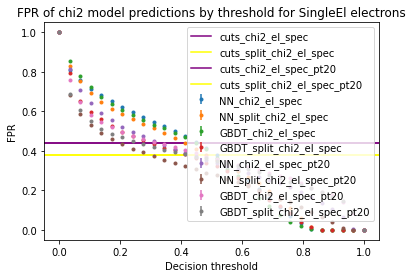

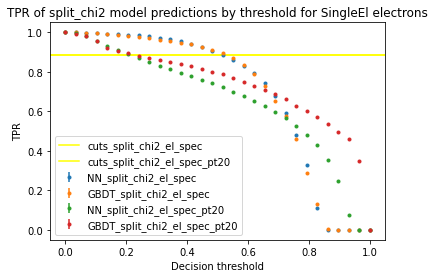

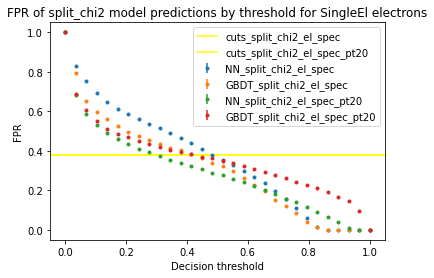

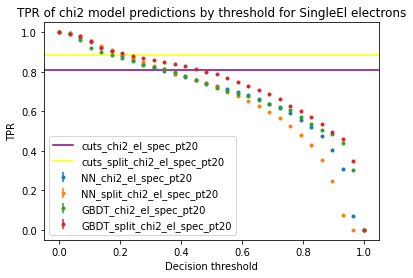

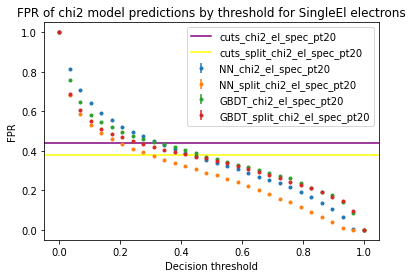

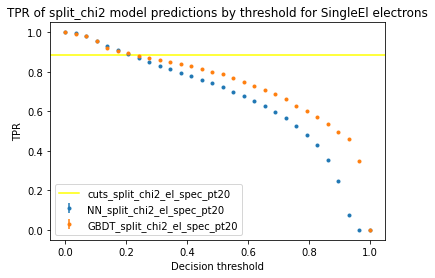

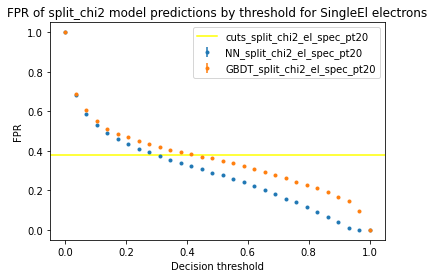

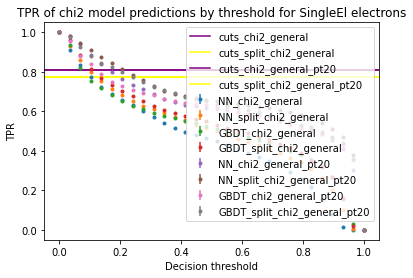

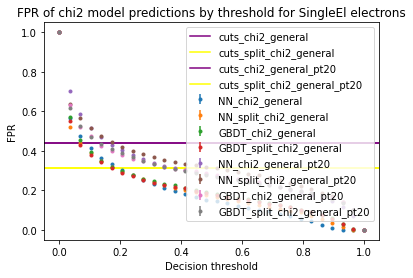

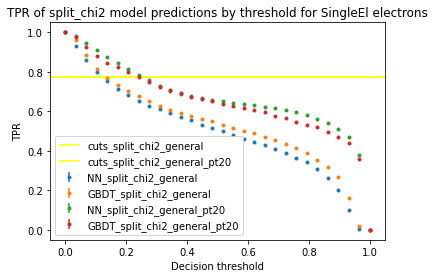

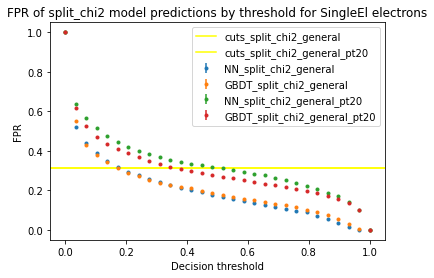

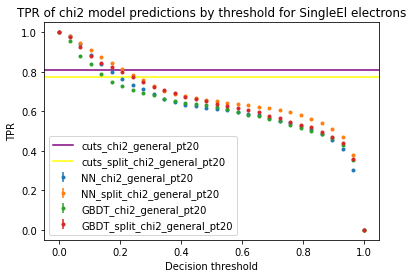

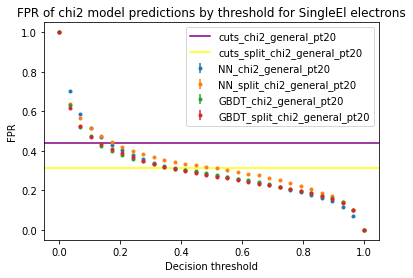

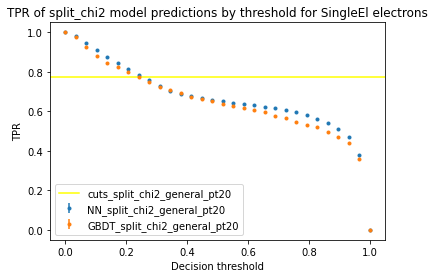

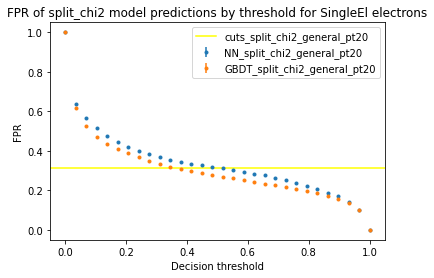

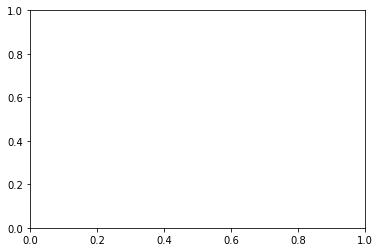

In [49]:
for test_ds, test_ds_name in zip([original_test_ds, single_el_test_ds], ["ZEE electrons", "SingleEl electrons"]):
                                                    # iterate through our two test datasets
    for train_dataset_name in train_dataset_names:  # iterate through names of trained-on datasets ("el_spec", etc.)
        for model_set_name in model_set_names:      # iterate through model set names ("chi2", "split_chi2")
            plot_tpr_fpr_by_threshold(test_ds, test_ds_name, train_dataset_name, model_set_name)

### ROC Curves

Plot the discriminators' paths through TPR/FPR space as the threshold on probablistically predicted labels changes. Also includes the cuts' point in that space.

In [44]:
def plot_rocs(test_ds, train_ds_name, model_set_name, xlims=(0, .5), ylims=(.7, 1)):
    """Takes in a dataset made of equal parts electrons and fakes and
    the model set name (which can also include the model train dataset
    if els_fakes_ds is the single_el_test_ds). Assumes that this dataset
    already has predictions with discriminator keys of the form "NN_{}",
    "GBDT_{}", and "cuts_{}"."""
    
    NN_pred_name = "NN_{}_{}".format(model_set_name, train_ds_name)
    GBDT_pred_name = "GBDT_{}_{}".format(model_set_name, train_ds_name)
    cut_pred_name = "cuts_{}_{}".format(model_set_name, train_ds_name)
    return ndmlplot.plot_rocs(test_ds, [NN_pred_name, GBDT_pred_name], [cut_pred_name], xlims=xlims, ylims=ylims)

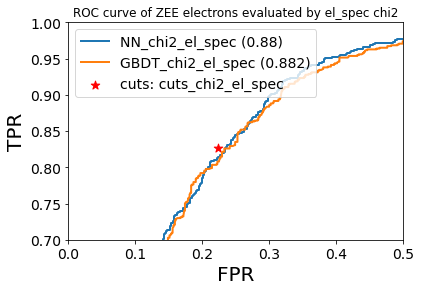

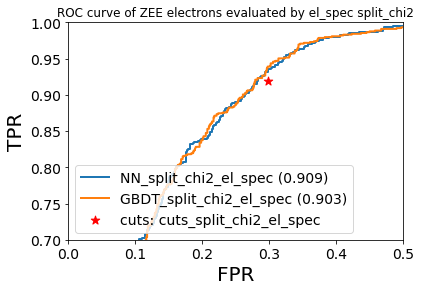

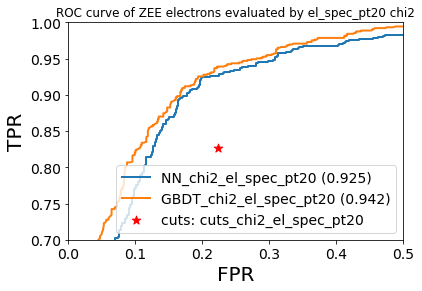

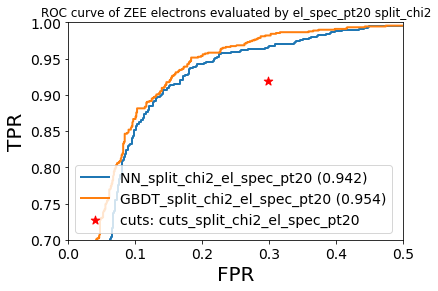

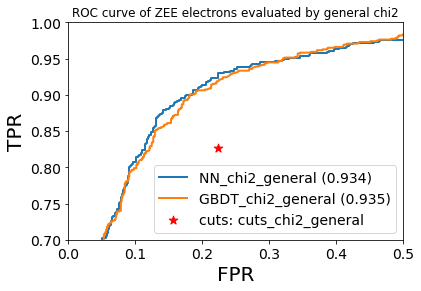

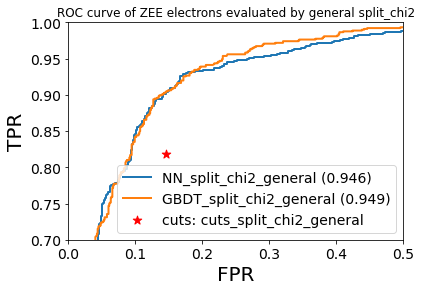

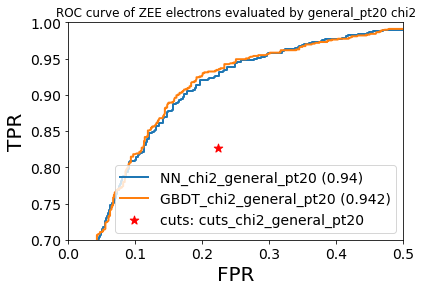

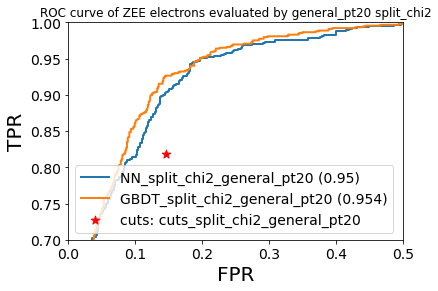

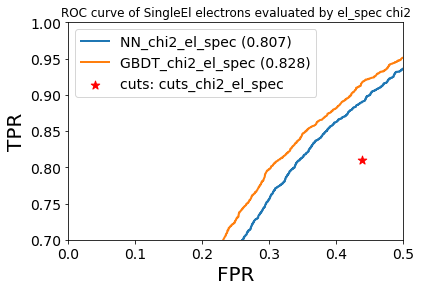

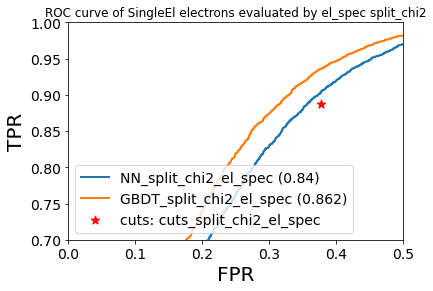

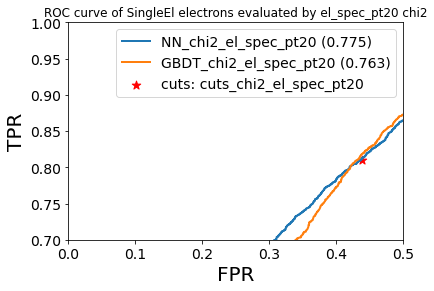

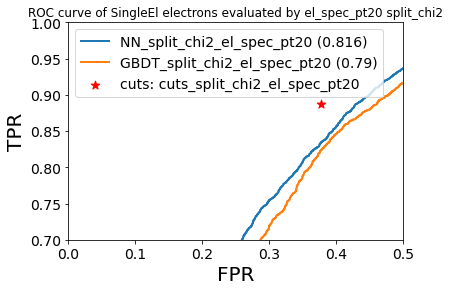

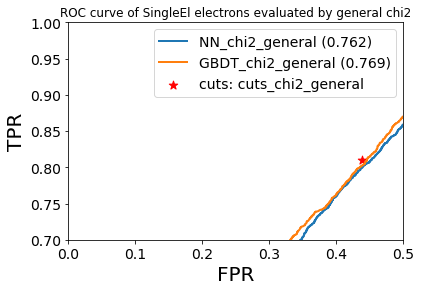

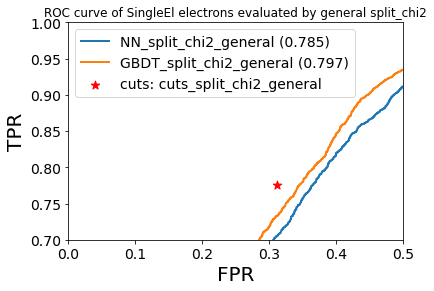

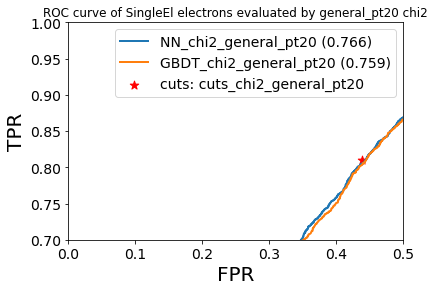

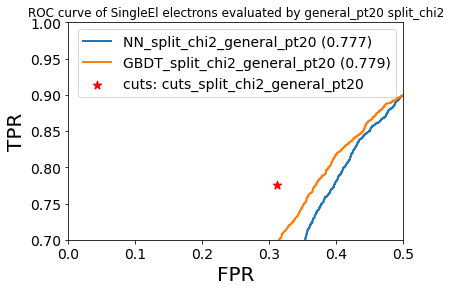

In [46]:
for test_ds, test_ds_name in zip([original_test_ds, single_el_test_ds], ["ZEE electrons", "SingleEl electrons"]):
                                                    # iterate through our two test datasets
    for train_dataset_name in train_dataset_names:  # iterate through names of trained-on datasets ("el_spec", etc.)
        for model_set_name in model_set_names:      # iterate through model set names ("chi2", "split_chi2")
            ax = plot_rocs(test_ds, train_dataset_name, model_set_name)
            ax.set_title("ROC curve of {} predicted by {} {}".format(test_ds_name, train_dataset_name, model_set_name))

### Particle TPR and FPR by Track Property

Plots TPR and FPR for particles of a particular type for binned values of some track property. The aim of this is to get a sense of how model performance depends upon track properties like pT and eta. Makes plots for both sets of models to compare performance.

In [50]:
def overlay_predictions_by_track_property(test_ds,
    pred_names, model_set_name, pred_comparison, pred_comp_name, binning_prop, bins, threshold):
    """Bin a set of predictions by some track property."""
    
    ax = gca()
    for pred_name in pred_names:
        ax = ndmlplot.plot_pred_comparison_by_track_property(
                test_ds, pred_name,
                pred_comparison, binning_prop, bins=bins, threshold=threshold,
                legend_id=pred_name, ax=ax)
    for line in ax.get_lines():
        line.set_linestyle("-")
        line.set_drawstyle("steps-mid")
        line.set_marker("")
    ax.set_ylabel(pred_comp_name)
    ax.set_title("{} of {} model predictions vs. {}; threshold of {}"
                 .format(pred_comp_name, model_set_name, binning_prop, threshold))
    ax.legend()
    show()
    cla()

In [54]:
def plot_predictions_by_track_property(test_ds, test_ds_name, train_ds_name):
    """A control function for the above 'overlay_predictions_by_track_property'."""

    # A dictionary from track properties to bin specifiers
    binning_dict = {"pt": (2, 100, 30)}
    threshold = 0.2

    # Get names of predictions for each model set
    split_chi2_preds = list(filter(lambda pred: "split" in pred and train_ds_name in pred,
                                   test_ds.get_all_prediction_names()))
    chi2_preds = list(filter(lambda pred: "split" not in pred and train_ds_name in pred,
                             test_ds.get_all_prediction_names()))

    for binning_prop, bins in zip(binning_dict.keys(), binning_dict.values()):  # Iterate through binning props
        for pred_comparison, pred_comp_name in zip(
                [ndmlpred.true_positive_rate, ndmlpred.false_positive_rate],
                ["TPR", "FPR"]):  # Iterate through prediction measurement types
            overlay_predictions_by_track_property(test_ds,
                split_chi2_preds, "split_chi2", pred_comparison, pred_comp_name, binning_prop, bins, threshold)
            overlay_predictions_by_track_property(test_ds,
                chi2_preds, "chi2", pred_comparison, pred_comp_name, binning_prop, bins, threshold)

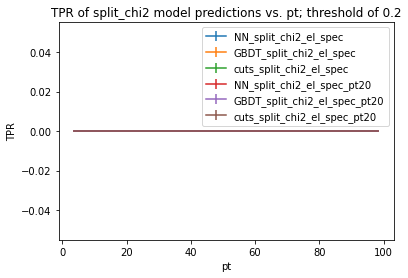

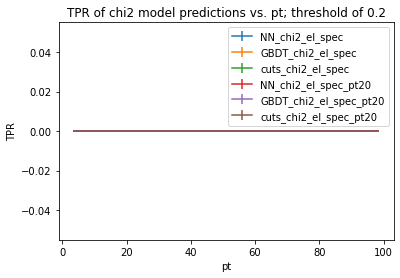

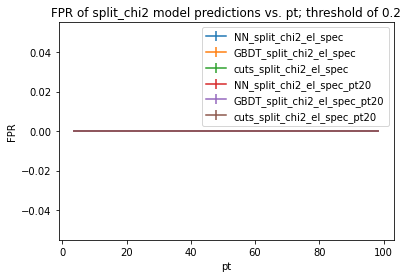

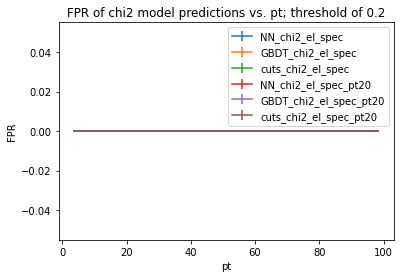

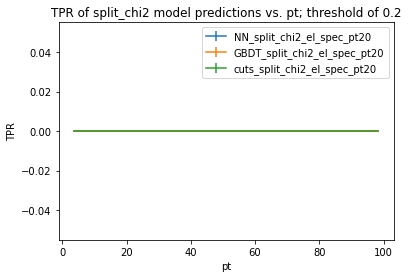

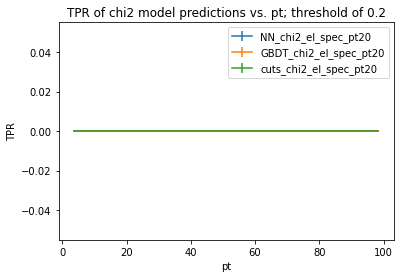

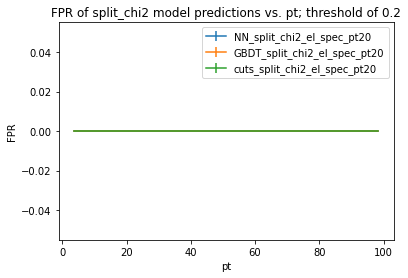

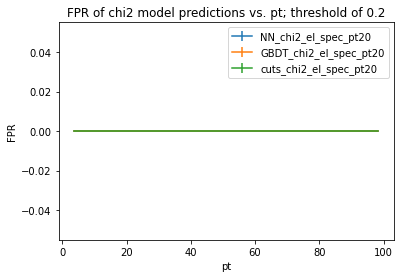

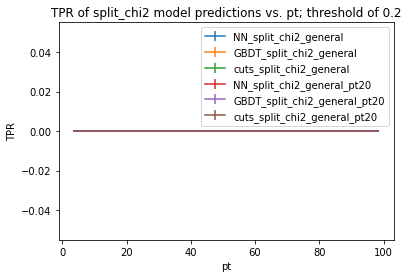

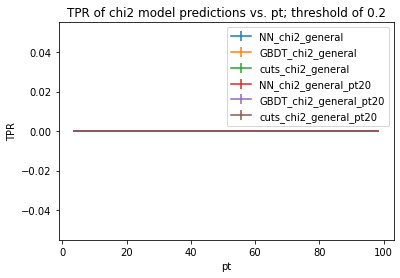

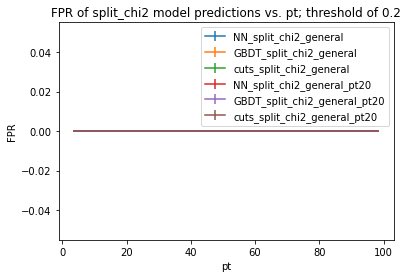

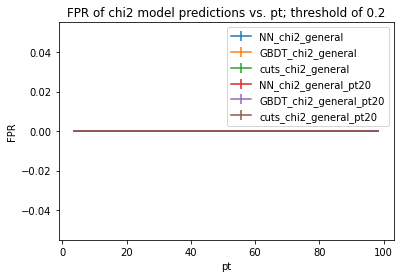

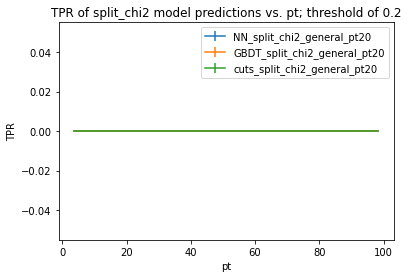

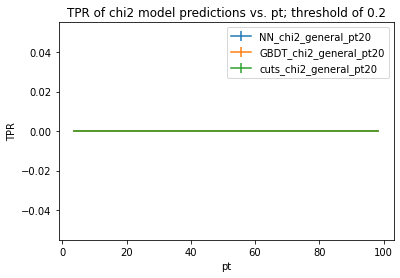

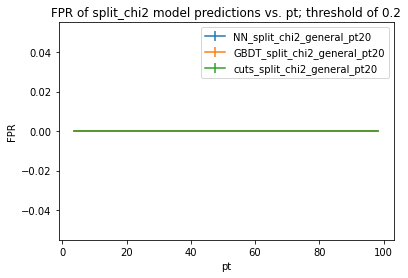

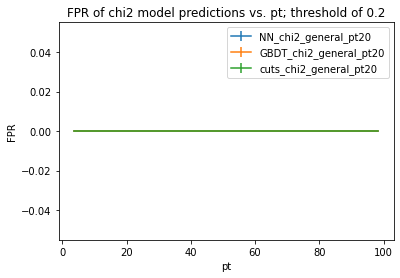

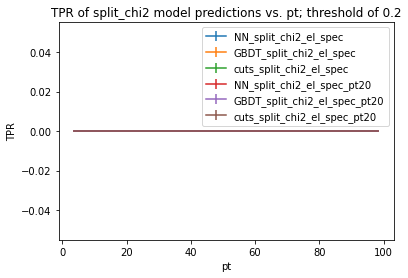

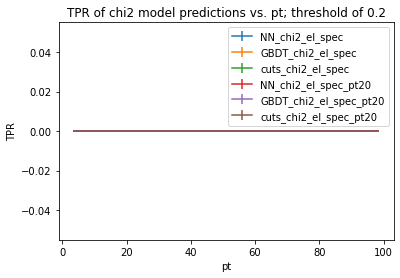

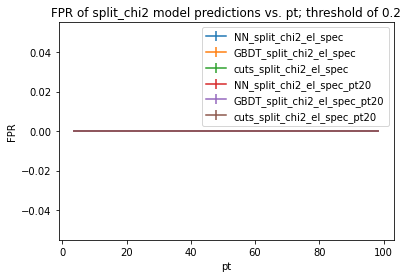

In [ ]:
for test_ds, test_ds_name in zip([original_test_ds, single_el_test_ds], ["ZEE electrons", "SingleEl electrons"]):
                                                    # iterate through our two test datasets
    for train_dataset_name in train_dataset_names:  # iterate through names of trained-on datasets ("el_spec", etc.)
        plot_predictions_by_track_property(test_ds, test_ds_name, train_dataset_name)

## Discussion

The goal of this study was twofold: to see whether a dedicated ML algorithm for electrons would benefit from the addition of a new set of "split chi2" variables: chi2rphi and chi2rz, and to see whether we needed fancy machine learning at all, and whether cuts would do.

As a part of both of these, graphs were made with repect to track properties to make sure that the models or cuts didn't discriminate based on track property.

First question first: **Do models trained on split chi2 variables perform better?**  
Answer: **Yes, a little bit.**

The area under a ROC curve (AUC) can be taken as a general measure of how well an algorithm performs in a predictive binary classification problem, and here the AUC for both models increases by 2-3% when they are allowed to train on chi2rz as opposed to chi2.

This isn't as much as we would expect, but it is something.

Next question: **Do the models perform enough better than cuts that we should use them?**  
Answer: **Yes, if we hold the computational time equal.**

Again with the ROC curve: although the split chi2 cuts are closer to the model curves, the curves still bound the points plotted by the cut sets with and without the split chi2 variables.

While models should reasonably take longer to produce output than a cut set should, this question is heavily specific to application and so has been ignored for this study.

Next question: **Do we need an electron-specific model at all?**  
Answer: **I'm not sure.**

I'll get to this later.

Last question: **Do either set of discriminators heavily discriminate against certain track properties?**  
Answer: **No, at least not for pT, eta, and z0.**

### Future Work

**Hyperparameter optimization**: The [hyperparameters](https://www.jeremyjordan.me/hyperparameter-tuning/) for the models were chosen using Claire Savard's (CU Boulder, graduate student) previous work on machine learning for the track-trigger.
However, her studies focused on trkMET cuts, and so her optimized hyperparameters could be different from those for this study.

**Tracklet seed variable**: Another variable indexed by track is the tracklet seed variable, which has its roots in the track-trigger algorithm (see page 16 of [this slideshow](https://wiki.classe.cornell.edu/pub/People/AndersRyd/170629_Tracklet_AWLC.pdf) for more information).
However, how tracklet seed would be used is a tricky question, as it isn't mappable to the real numbers like pT, eta, or a number of missing moules is.
More thought should be put into it.

### Conclusion: The Verdict, In A Sentence

Models are more performant than cuts on discriminating between primary electrons and fake tracks, and both cuts and models using the chi2rz property are more performant than cuts and models using only the chi2 property.
Leaving the question of computational resources and time up to the implementation, **models trained on chi2rz are the best way to discriminate between primary-interaction electrons and fake tracks**.

Further work should be done to optimize model hyperparameters and to make use of tracklet seed.